In [15]:
#Importing Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [16]:
#Get the Stock Quote
df=pd.read_csv('AAPL.csv')
#Show the Data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.629209,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.697079,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.838044,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.972249,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.951672,394024400


In [17]:
#Check Shape of Data
df.shape

(2388, 7)

<function matplotlib.pyplot.show(close=None, block=None)>

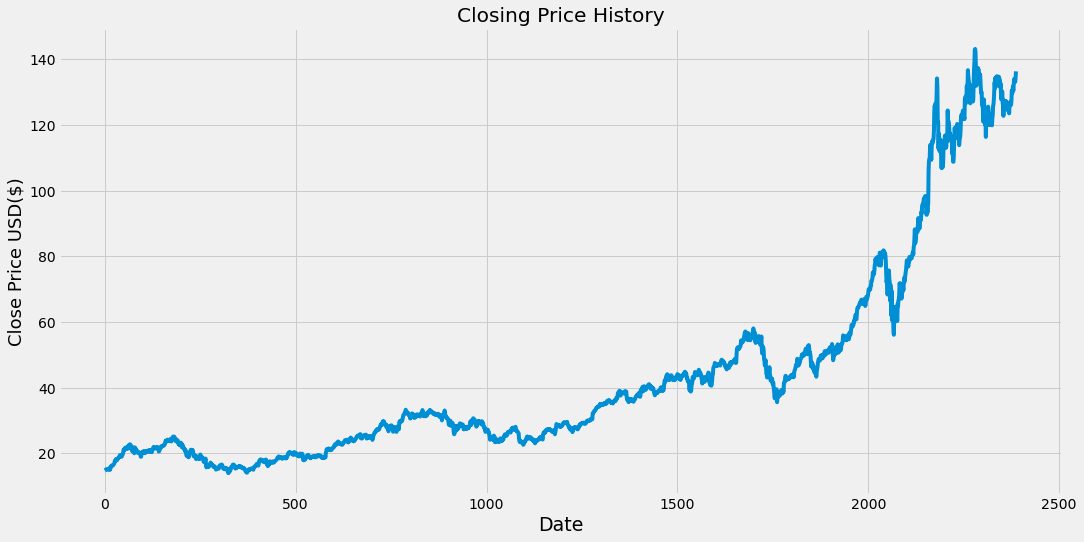

In [18]:
#Visualize Closing price History
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=19)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show

In [19]:
#Create a new Data Frame with only the close column
data=df.filter(['Close'])
#Convert Data Frame to a numpy array
dataset= data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*0.8)
training_data_len

1911

In [20]:
#Scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00572147],
       [0.00633231],
       [0.00760099],
       ...,
       [0.92222113],
       [0.93514556],
       [0.94714132]])

In [21]:
#Create the Training Dataset
#Create the scaled training data set
train_data=scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train
x_train=[]
y_train=[]
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00572147, 0.00633231, 0.00760099, 0.00880885, 0.00862367,
       0.00904103, 0.00885031, 0.00852969, 0.00809298, 0.00944457,
       0.0106635 , 0.0102876 , 0.00822841, 0.01019362, 0.00825882,
       0.01551431, 0.01495322, 0.01568568, 0.01726944, 0.01822855,
       0.0181484 , 0.01785265, 0.01911303, 0.02029878, 0.02164209,
       0.02381183, 0.02836965, 0.02843876, 0.03097611, 0.03287221,
       0.02961347, 0.03086831, 0.03084344, 0.03436201, 0.03386172,
       0.03478765, 0.03645157, 0.03737752, 0.04004478, 0.04198786,
       0.04254895, 0.04274521, 0.03942289, 0.03862132, 0.03874017,
       0.04186349, 0.04274244, 0.04463025, 0.04908028, 0.05501735,
       0.05390621, 0.05390898, 0.05820146, 0.05954478, 0.05858842,
       0.05771501, 0.05680565, 0.05982669, 0.0618997 , 0.06276759])]
[0.06062272425275497]



In [22]:
#convert the x_train and y_train datatset to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

In [23]:
#Reshape the data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1851, 60, 1)

In [24]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [25]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [26]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1851/1851 [==============================] - 57s 21ms/step - loss: 4.8976e-04


In [27]:
model.save("saved_model.h5")

In [28]:
#Create the testing dataset
#Create a new array containing scaled values from index 1851 to 2003
test_data=scaled_data[training_data_len - 60: , :]
#Create the datasets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


In [29]:
#Convert the data to a numpy array
x_test=np.array(x_test)

In [30]:
#Reshape the data
x_test= np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1))

In [31]:
#get the models predicted price values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [32]:
#Get the root mean square error [RMSE]
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.2860591843723235

<ipython-input-33-4f6d7f50e7c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


<function matplotlib.pyplot.show(close=None, block=None)>

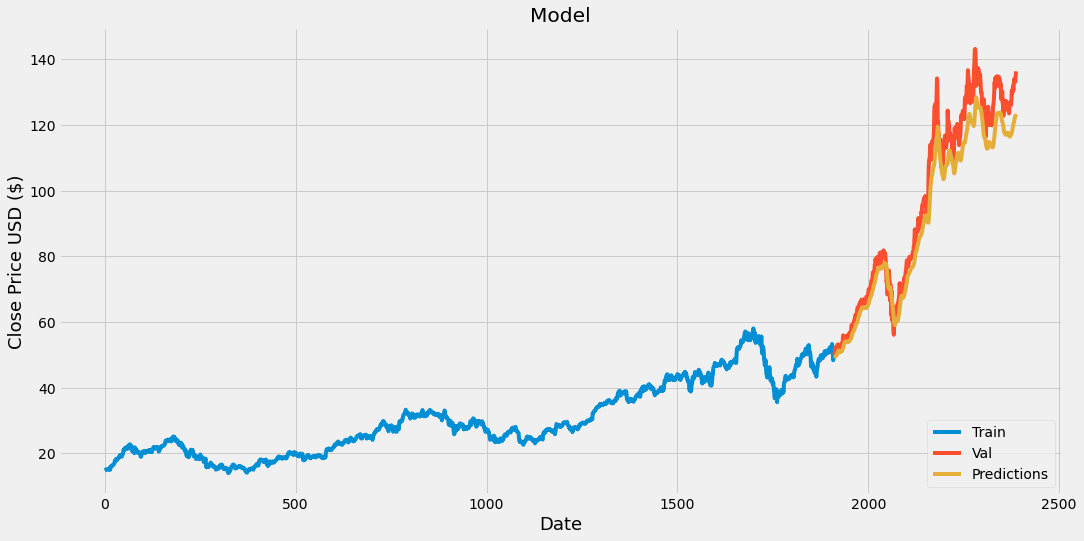

In [33]:
#Plot the data
train=data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']=predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show

In [34]:
#Show the valid and Predicted Prices
valid

,Close,Predictions
1911,50.857498,49.780674
1912,50.247501,49.619690
1913,50.119999,49.522152
1914,52.242500,49.454868
1915,50.687500,49.678062
...,...,...
2383,133.699997,121.693748
2384,133.410004,122.283669
2385,133.110001,122.711876
2386,134.779999,122.965515


In [35]:
#Get the quote
apple_quote=web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2021-06-29')
#Create a new dataframe
new_df=apple_quote.filter(['Close'])
#Get the last 60 day closing price Values and convert the dataframe to an array
last_60_days=new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scale=scaler.transform(last_60_days)
#create an Empty list
X_test=[]
#Append the past 60 days 
X_test.append(last_60_days_scale)
#Convert the X_test data set to a numpy array
X_test=np.array(X_test)
#Reshape the data
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicted scaled price
pred_price=model.predict(X_test)
#Undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/AAPL/history?period1=1325370600&period2=1625005799&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [52]:
#Get the qote
apple_quote2=web.DataReader('AAPL',data_source='yahoo',start='2021-06-29',end='2021-06-29')
print(apple_quote2['Close'])

Date
2021-06-28    134.779999
2021-06-29    136.330002
Name: Close, dtype: float64
